In [6]:
import os
import csv
import time
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

from utils import print_model_information, make_simulations, generate_gaussian_peaks, solve_heat_equation_2d, solve_wave_equation_2d

from simulation_class import SimulationModel

# from network_architectures import VAE, VAE2

Structure of the script:

In [31]:
# # Generate training data
equation_type = "heat"
equation_parameter = 3
dimension = 100

# inputs_train, output_train = make_simulations(number=150, k=1, nt=150, equation=equation_type, equation_parameter=equation_parameter, as_tensor=True, nx=100, ny=100)
inputs_train, output_train = make_simulations(number=20, k=1, nt=100, equation=equation_type, equation_parameter=equation_parameter, as_tensor=True, nx=dimension, ny=dimension)

perm = torch.randperm(inputs_train.size(0))
perm_idx = torch.argsort(perm)

inputs_train = inputs_train[perm]
output_train = output_train[perm]
output_train = 1

inputs_train = inputs_train.unsqueeze(1)

torch.save(inputs_train, f'model_parameters/vae/{equation_type}_par{equation_parameter}_dim{dimension}.pth')

In [51]:
class VAE10(nn.Module):
    def __init__(self, latent_dim=64, first_channel=16):
        super(VAE10, self).__init__()
        
        self.name = f"vae_ld{latent_dim}_fc{first_channel}"

        self.first_channel = first_channel
        self.latent_dim = latent_dim
        
        self.dim = 7    # I want to compute this automatically.
        self.doubler = 2**(4-1) # double number of channels every extra layer

        self.encoder = nn.Sequential(
            nn.Conv2d(1, self.first_channel, kernel_size=3, stride=2, padding=1),  # 100x100 -> 50x50
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.first_channel, 2*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 25x25
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2*self.first_channel, 4*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 12x12
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(4*self.first_channel, 8*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 12x12
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.flatten_size = self.doubler*self.first_channel * self.dim**2
        
        self.fc1 = nn.Linear(self.flatten_size, self.latent_dim)  # Mapping channels to a mean
        # self.fc1 = nn.Linear(self.flatten_size, self.latent_dim)  # Mapping channels to a mean
        self.fc2 = nn.Linear(self.flatten_size, self.latent_dim)  # Mapping channels to a standard deviation

        # From mean and stdev of fc1 and fc2, we sample gaussians (z). Those are then transformed (or unflattened?)
        self.fc3 = nn.Linear(self.latent_dim, self.flatten_size)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8*self.first_channel, 4*self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=0),  # 25x25 -> 50x50
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(4*self.first_channel, 2*self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=0),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(2*self.first_channel, self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=1),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(self.first_channel, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten: 32 x 2*first_channel*25*25
        mu = self.fc1(x)           # Mean
        logvar = self.fc2(x)       # Log variance
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        x = self.fc3(z)  # (B, latent_dim) -> (B, 2*first_channel*25*25)
        # Reshape for the decoder: batch_size x channels x height x width
        x = x.view(-1, self.doubler*self.first_channel, self.dim, self.dim)
        return self.decoder(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)  # Get mean and log variance
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        reconstructed_x = self.decode(z)  # Decode back to original space
        return reconstructed_x, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar, beta=1.0):
        MSE = F.mse_loss(recon_x, x, reduction='sum')  
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + beta * KLD

    def summary(self):
        pass

device = "cpu"
vae = VAE10(latent_dim=128, first_channel=16).to(device) 

# For testing purposes
with torch.no_grad():
    tester = torch.randn(32, 1, 100, 100)
    vae.encoder(tester)
    lol, wut = vae.encode(tester)
    yuh = vae.reparameterize(lol,wut)
    vae.decode(yuh).shape

    test = vae.encoder(torch.randn(32, 1, 100, 100))
    print(test.shape, lol.shape, wut.shape, vae.decode(yuh).shape)

torch.Size([32, 128, 7, 7]) torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32, 1, 100, 100])


In [9]:
if os.path.isfile(f'model_parameters/vae/{vae.name}.pth'):
    vae.load_state_dict(torch.load(f'model_parameters/vae/{vae.name}.pth', weights_only=True))

if os.path.isfile(f'model_parameters/vae/{vae.name}_data.pth'):
    inputs_train = torch.load(f'model_parameters/vae/{vae.name}_data.pth').values()

In [94]:
x=10

In [ ]:
x = x**0.99
x

2.1905926506135427

In [32]:
inputs_loader = DataLoader(inputs_train, batch_size=128, shuffle=True)
num_samples, _, _, _ = inputs_train.shape

def lr_lambda(epoch):
    start_lr = 0.001
    end_lr = 0.0001
    total_steps = 500
    return (end_lr - start_lr) * (epoch / total_steps) + start_lr 

optimizer = optim.Adam(vae.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

In [ ]:
num_epochs = 1000
print_every = 20

beta_current = 10
beta_decay_rate = 0.99

start_time = time.time()
for epoch in range(num_epochs):

    vae.train()  # Training mode
    running_loss = 0.0
    beta_current **= beta_decay_rate
    print(beta_current)

    for data in inputs_loader: 
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae.forward(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar, beta=)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % print_every == 0:
        epoch_loss = running_loss / len(inputs_loader.dataset)
        
        total_time_sec = time.time() - start_time
        average_epoch_time = round(total_time_sec / (epoch + 1), 2)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | | Total time {round(total_time_sec/60, 1):.2f} min at {average_epoch_time:.1f} sec per epoch") 
        
        torch.save(vae.state_dict(), f'model_parameters/vae/{vae.name}_parameters.pth')  

Epoch [20/1000] | Train Loss: 14.6997 | | Total time 0.50 min at 1.6 sec per epoch
Epoch [40/1000] | Train Loss: 14.2533 | | Total time 1.10 min at 1.7 sec per epoch
Epoch [60/1000] | Train Loss: 14.1984 | | Total time 2.20 min at 2.2 sec per epoch
Epoch [80/1000] | Train Loss: 13.9246 | | Total time 2.90 min at 2.2 sec per epoch
Epoch [100/1000] | Train Loss: 13.7954 | | Total time 3.50 min at 2.1 sec per epoch
Epoch [120/1000] | Train Loss: 13.6844 | | Total time 4.40 min at 2.2 sec per epoch
Epoch [140/1000] | Train Loss: 13.5792 | | Total time 5.10 min at 2.2 sec per epoch
Epoch [160/1000] | Train Loss: 13.4119 | | Total time 5.80 min at 2.2 sec per epoch
Epoch [180/1000] | Train Loss: 13.3237 | | Total time 7.20 min at 2.4 sec per epoch
Epoch [200/1000] | Train Loss: 13.3510 | | Total time 8.00 min at 2.4 sec per epoch
Epoch [220/1000] | Train Loss: 13.1709 | | Total time 9.80 min at 2.7 sec per epoch
Epoch [240/1000] | Train Loss: 13.0597 | | Total time 10.80 min at 2.7 sec per e

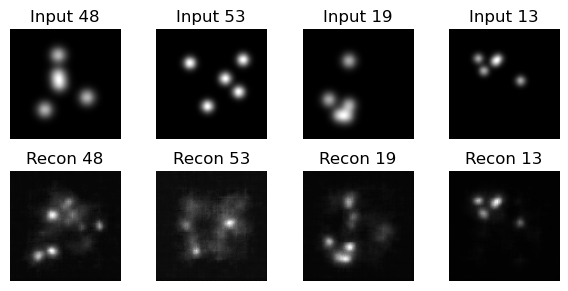

In [50]:
inputs_train = inputs_train[perm_idx] # Sorting to right format

reconstructed_x = []

with torch.no_grad():
    for batch in inputs_loader:
        recon_x, mu, logvar = vae.forward(batch)        
        reconstructed_x.append(recon_x)

reconstructed_x = torch.cat(reconstructed_x, dim=0)
reconstructed_x = reconstructed_x[perm_idx]

# Plotting

recon_x, mu, logvar = vae.forward(batch)  


num_subsamples = 4
indices = torch.randint(0, num_samples, (num_subsamples,))

indices = torch.randint(0, batch.shape[0], (num_subsamples,))

fig, axes = plt.subplots(2, num_subsamples, figsize=(6, 3))
for i, idx in enumerate(indices):
    axes[0, i].imshow(batch.squeeze(1)[idx].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Input {idx.item()}')
    axes[0, i].axis('off')  

    axes[1, i].imshow(recon_x.squeeze(1)[idx].detach().numpy(), cmap='gray')
    axes[1, i].set_title(f'Recon {idx.item()}')
    axes[1, i].axis('off')  
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Latent representation')

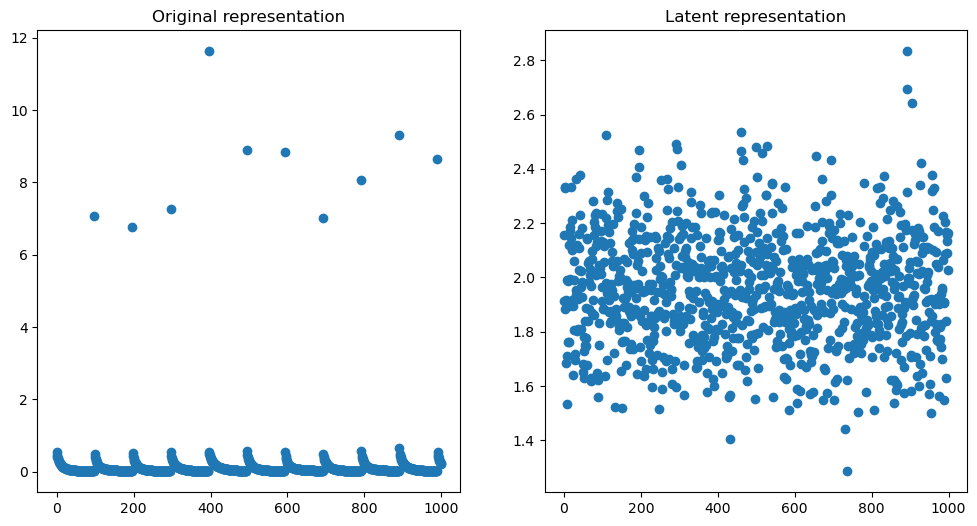

In [ ]:
distances_normal = torch.linalg.norm(inputs_train[:-1, 0, :, :] - inputs_train[1:, 0, :, :], dim=(1,2))
distances_latent = torch.linalg.norm(reconstructed_x[:-1, 0, :, :] - reconstructed_x[1:, 0, :, :], dim=(1,2))

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(range(1000), distances_normal[:1000])
axes[0].set_title("Original representation")
axes[1].scatter(range(1000), distances_latent[:1000])
axes[1].set_title("Latent representation")

Get random frames. Compare the visual reconstruction with the visual original. Just sample a bunch

How do they "flow" through the latent space? We can frankly only check the 2 dimensions at a time, let's select those randomly!

In [56]:
indices = torch.randint(0, 100, (50,))
result = torch.stack([all_mu[(149*i+1):(149*i+1)+148, :] for i in indices])

dimensions =  torch.randint(0, 128, (2,))

plt.figure(figsize=(10, 6))

for i, idx in enumerate(indices):
    selected_data = all_mu[(149*i+1):(149*i+1)+148, :]
    scatter_points = selected_data[:, dimensions]
    plt.scatter(scatter_points[:, 0], scatter_points[:, 1], label=f"Flow {i+1}")

RuntimeError: stack expects each tensor to be equal size, but got [148, 64] at entry 0 and [0, 64] at entry 1

TEST WITH DEEPER NEURAL NETWORK. CAN WE GET A BETTER EMBEDDING?

In [ ]:
class VAE10(nn.Module):
    def __init__(self, latent_dim=64, first_channel=16):
        super(VAE10, self).__init__()
        
        self.first_channel = first_channel
        self.latent_dim = latent_dim
        
        self.dim = 7    # I want to compute this automatically.
        self.doubler = 2**(4-1) # double number of channels every extra layer

        self.encoder = nn.Sequential(
            nn.Conv2d(1, self.first_channel, kernel_size=3, stride=2, padding=1),  # 100x100 -> 50x50
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.first_channel, 2*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 25x25
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2*self.first_channel, 4*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 12x12
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(4*self.first_channel, 8*self.first_channel, kernel_size=3, stride=2, padding=1),  # 50x50 -> 12x12
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.flatten_size = self.doubler*self.first_channel * self.dim**2
        
        self.fc1 = nn.Linear(self.flatten_size, self.latent_dim)  # Mapping channels to a mean
        self.fc2 = nn.Linear(self.flatten_size, self.latent_dim)  # Mapping channels to a standard deviation

        # From mean and stdev of fc1 and fc2, we sample gaussians (z). Those are then transformed (or unflattened?)
        self.fc3 = nn.Linear(self.latent_dim, self.flatten_size)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8*self.first_channel, 4*self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=0),  # 25x25 -> 50x50
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(4*self.first_channel, 2*self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=0),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(2*self.first_channel, self.first_channel, kernel_size=3, stride=2, padding=1, output_padding=1),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(self.first_channel, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 50x50 -> 100x100
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten: 32 x 2*first_channel*25*25
        mu = self.fc1(x)           # Mean
        logvar = self.fc2(x)       # Log variance
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        x = self.fc3(z)  # (B, latent_dim) -> (B, 2*first_channel*25*25)
        # Reshape for the decoder: batch_size x channels x height x width
        x = x.view(-1, self.doubler*self.first_channel, self.dim, self.dim)
        return self.decoder(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)  # Get mean and log variance
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        reconstructed_x = self.decode(z)  # Decode back to original space
        return reconstructed_x, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar, beta=1.0):
        MSE = F.mse_loss(recon_x, x, reduction='sum')  
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + beta * KLD

    def summary(self):
        pass

device = "cpu"
vae = VAE10(latent_dim=128, first_channel=16).to(device) 

# For testing purposes
with torch.no_grad():
    tester = torch.randn(32, 1, 100, 100)
    vae.encoder(tester)
    lol, wut = vae.encode(tester)
    yuh = vae.reparameterize(lol,wut)
    vae.decode(yuh).shape

    test = vae.encoder(torch.randn(32, 1, 100, 100))
    print(test.shape, lol.shape, wut.shape, vae.decode(yuh).shape)

torch.Size([32, 128, 7, 7]) torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32, 1, 100, 100])


In [99]:
inputs_loader = DataLoader(inputs_train, batch_size=128, shuffle=True)

optimizer = optim.Adam(vae.parameters(), lr=0.01)
 
num_epochs = 5000
print_every = 50

def lr_lambda(epoch):
    start_lr = 0.01
    end_lr = 0.0001
    total_steps = 1000
    return (end_lr - start_lr) * (epoch / total_steps) + start_lr  # Linear decay

# Define LambdaLR scheduler
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

for epoch in range(num_epochs):
    vae.train()  # Training mode
    running_loss = 0.0
    for data in inputs_loader: 
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae.forward(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % print_every == 0:
        epoch_loss = running_loss / len(inputs_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [50/5000], Loss: 13.5081
Epoch [100/5000], Loss: 12.4404
Epoch [150/5000], Loss: 11.3592
Epoch [200/5000], Loss: 10.7649
Epoch [250/5000], Loss: 10.2015
Epoch [300/5000], Loss: 9.7602
Epoch [350/5000], Loss: 9.3004
Epoch [400/5000], Loss: 8.8254
Epoch [450/5000], Loss: 8.3815
Epoch [500/5000], Loss: 8.0188
Epoch [550/5000], Loss: 7.6564
Epoch [600/5000], Loss: 7.3739
Epoch [650/5000], Loss: 7.1088
Epoch [700/5000], Loss: 6.8578
Epoch [750/5000], Loss: 6.8170
Epoch [800/5000], Loss: 6.6688
Epoch [850/5000], Loss: 6.5712
Epoch [900/5000], Loss: 6.4364
Epoch [950/5000], Loss: 6.3679
Epoch [1000/5000], Loss: 6.3158
Epoch [1050/5000], Loss: 6.2079
Epoch [1100/5000], Loss: 6.2147
Epoch [1150/5000], Loss: 6.0890
Epoch [1200/5000], Loss: 6.0397
Epoch [1250/5000], Loss: 5.9510
Epoch [1300/5000], Loss: 5.9870
Epoch [1350/5000], Loss: 5.9927
Epoch [1400/5000], Loss: 5.9170
Epoch [1450/5000], Loss: 5.7972
Epoch [1500/5000], Loss: 5.8686
Epoch [1550/5000], Loss: 5.9122
Epoch [1600/5000], Loss

In [ ]:
vae

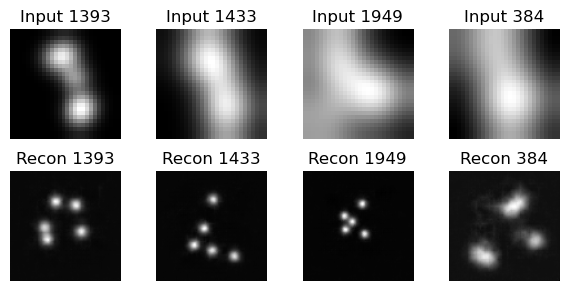

In [141]:
reconstructed_x = []

with torch.no_grad():
    for data in inputs_loader: 
        recon_x, mu, logvar = vae.forward(data)
        reconstructed_x.append(recon_x)

reconstructed_x = torch.cat(reconstructed_x, dim=0)
reconstructed_x = reconstructed_x[perm_idx]

# Plotting
    
num_samples = 4
indices = torch.randint(0, reconstructed_x.shape[0], (num_samples,))
# indices = torch.tensor([1,2,3,4])

fig, axes = plt.subplots(2, num_samples, figsize=(6, 3))

for i, idx in enumerate(indices):
    axes[0, i].imshow(inputs_train_ordered.squeeze(1)[idx].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Input {idx.item()}')
    axes[0, i].axis('off')  

    axes[1, i].imshow(reconstructed_x.squeeze(1)[idx].cpu().numpy(), cmap='gray')
    axes[1, i].set_title(f'Recon {idx.item()}')
    axes[1, i].axis('off')  
    
plt.tight_layout()
plt.show()

In [131]:
reconstructed_x = []

with torch.no_grad():
    for data in inputs_loader: 
        recon_x, mu, logvar = vae.forward(data)
        reconstructed_x.append(recon_x)

reconstructed_x = torch.cat(reconstructed_x, dim=0)
reconstructed_x = reconstructed_x[perm_idx]

Text(0.5, 1.0, 'Latent representation')

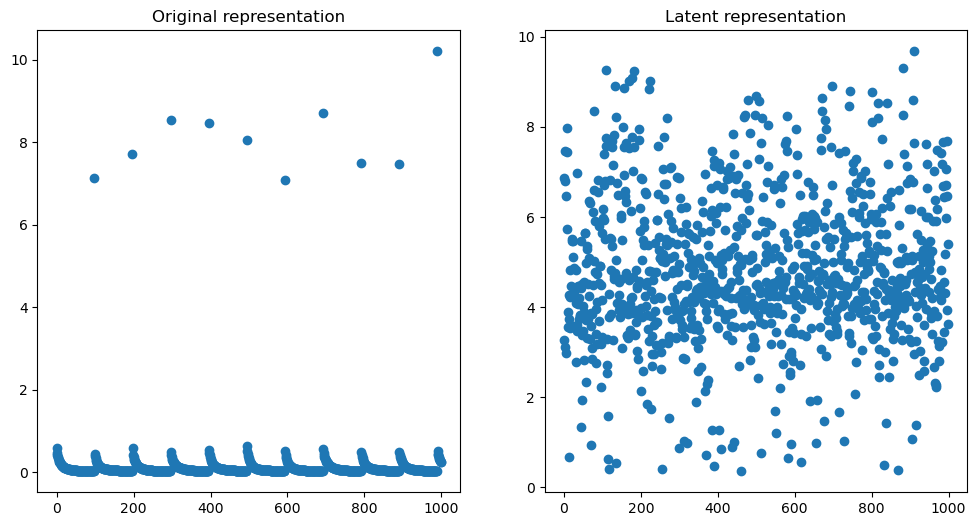

In [127]:
distances_normal = torch.linalg.norm(inputs_train_ordered[:-1, 0, :, :] - inputs_train_ordered[1:, 0, :, :], dim=(1,2))
distances_latent = torch.linalg.norm(reconstructed_x[:-1, 0, :, :] - reconstructed_x[1:, 0, :, :], dim=(1,2))

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(range(1000), distances_normal[:1000])
axes[0].set_title("Original representation")
axes[1].scatter(range(1000), distances_latent[:1000])
axes[1].set_title("Latent representation")
